# Predicting Patient Outcomes of Artificial Heart Implant

The artificial heart, VAD (ventricular assist device), is an implantable electromechanical device used to partially replace the function of a heart. It is the last therapeutic treatment for people in end-stage heart failure. VADs were expected to extend patients lives for several years. However, many patients who received VADs died shortly after the implant.

In this project, I mine previous VAD recipients' clinical records and outcomes, and build machine learning models that can help physicians to predict the likely outcome of each implant.

<img src="https://www.mayoclinic.org/-/media/kcms/gbs/patient-consumer/images/2013/11/15/17/38/my01077_my00361_im04277_mcdc7_lvadthu_jpg.jpg", width=250>

#### Data Science Problem, Goal and Prior Work: 

I used the [INTERMACS dataset](https://intermacs.uab.edu/) for this project. This dataset includes 23,787 patients' clinical data relevant to mechanical circulatory support devices (VAD is one kind of such devices) from initial hospitalization through post-implant follow-up evaluations. Their pre-implant clinical conditions served as starting places for my feature engineering, and the time interval between their implant and death/explant is the training labels.

Comparable previous works on VAD implant prognostics using INTERMACS data most often used linear regression or Bayesian models. The accuracy of one-year mortality predictions is [83%](http://d-scholarship.pitt.edu/25529/) to [84.5%](https://www.ncbi.nlm.nih.gov/pubmed/26820445).

** Table of Content: **

1. [Data Preparation](#preprocessing)
2. [Problem Setup and Baseline](#baseline)
3. [Data Exploration, Cleaning and Visualization](#cleaning)
    - [Overview and transform prediction targets](#3-1)
    - [Dealing with and utilizing (lots of) missing values](#3-2)
    - [Managing feature redundancy](#3-3)
    - [Managing observation redundancy](#3-4)
    
2. [Supervised Learning](#supervised)
3. ["Divide and Conquer"](#divide)
4. [Explorations for Future Work](#other)
    - Prognostic Fairness
    - Patient Clustering
    - Deep Learning
5. [Conclusion and Lessons Learned](#sum)
6. [Reference](#reference)

In [672]:
# utility
import pandas as pd
import numpy as np
import json
from collections import Counter
def pprintDict(d):
    '''pretty print dictionary'''
    print(json.dumps(d, sort_keys=True, indent=4))
import warnings
warnings.simplefilter('ignore')

# stats and machine learning
import math
import random as rand 
import scipy.stats as stats
import scipy.sparse as sp
from sklearn import dummy, preprocessing, feature_selection, feature_extraction, metrics, model_selection
from sklearn import tree, multiclass, svm, ensemble, gaussian_process, neighbors
from sklearn.linear_model import LinearRegression
# from point import Point

from imblearn.combine import SMOTETomek # https://github.com/scikit-learn-contrib/imbalanced-learn

# visualization
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_style("white")
sns.set_palette("PuBuGn_d")
from matplotlib.ticker import FuncFormatter
%matplotlib inline

---
<a id="preprocessing"></a>
## 1 - Data Preparation

### 1.1 - Consolidating INTERMACS databases

I elicited data of the patients who have received VAD implants and have died or explanted. 

- Combine four INTERMACS databases. Here I took all columns as objects (str) for the moment.
    - ```patient_INTERMACS_Data_Dictionary.csv```
    - ```device_INTERMACS_Data_Dictionary.csv```
    - ```followup_INTERMACS_Data_Dictionary.csv```
- Elicitating patients who eventually received an artificial heart;
- Focusing on first-time implant patients;
- Seperating pre-implant and post-implant variables;
- Set INT_DEAD (integer) as label.

In [2]:
from dataprep import feature_dict, import_and_join

# Import Data
feature_dict = feature_dict()
df, input_col, outcome_col, idx_col = import_and_join(feature_dict)
df.head()

Integrated and imported 551 input columns, 118 output columns and 5821 observations.


,PATIENT_ID,CC_ADVANCED_AGE_M,CC2_ADVANCED_AGE_M,CC_ALLOSENSITIZATION_M,CC2_ALLOSENSITIZATION_M,CC_CHRONIC_COAGULOPATHY,CC2_CHRONIC_COAGULOPATHY,CC_CHRONIC_INF_CONCERNS_M,CC2_CHRONIC_INF_CONCERNS_M,CC_CHRONIC_RENAL_DISEASE_M,...,OP4EXPL,OP4EXPREA,OP4INTD,OP4INTR,OP4INTT,OP4REC,OP4TXPL,TRANSFER_CARE,TREC_PT,TXPL_PT
2,12,Missing,No,Missing,No,Missing,Missing,Missing,No,Missing,...,0.0,nan,7.162364730299999,7.162364730299999,7.162364730299999,0.0,0.0,nan,0.0,0.0
3,12,No,No,No,No,No,No,No,No,No,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,12,No,No,No,No,No,No,No,No,No,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,12,No,No,No,No,No,No,Yes,Yes,No,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,13,Missing,No,Missing,No,Missing,Missing,Missing,No,Missing,...,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0


In [3]:
pprintDict(feature_dict['LVEF'])

{
    "FORMAT": "ISF_LVEF.",
    "FORMAT_VALUE": {
        "1": "> 50 (normal)",
        "2": "40-49 (mild)",
        "3": "30-39 (moderate)",
        "4": "20-29 (moderate/severe)",
        "5": "Not Recorded or Not Documented",
        "6": "< 20 (severe)",
        "998": "~Unknown~"
    },
    "LABEL": "LVEF",
    "TYPE": "Num"
}


### 1.2 - Correcting Data Types and Value Mappings

The feature dictionary shows the current *encoding* of the dataset is largely impropriate.
- Many numeric attributes in the data do not represent numeric meanings or distances, and same as nominal attributes. 
- Missing values are also often represented with strings, numbers and others. When importing the databases, we have dealt with common NaN encodings but not others ('998', '-', 'Not Done', 'Unknown', '~Unknown~', etc.) 
- Even worse is that columns with name that ends with `_M` have already been mapped to a different set of value during data collection, require us to "de-code" them back. 

    For exmaple, the "LVEF" (left ventricular ejection fraction, the percentage number of total amount of blood in the left ventricle is pumped out with each heartbeat) attribute is represented as below. Encoding "Not Recorded or Not Documented" as "5" doesn't really make sense. Similarly dangerous is to interpret '998' as numeric instead of NaN.

| value encoding in the raw data  | actual LVEF value |
|     :---:      |     :---:      |
| 1  | > 50 (normal)  |
| 2  | 40-49 (mild)  |
| 3  | 30-39 (moderate)  |
| 4  | 20-29 (moderate/severe)  |
| 5  | **Not Recorded or Not Documented**  |
| 6  | < 20 (severe) |
| 998 | **~Unknown~**|


    





To correct these messy data encodings, I used two approach. 
- I extracted mappings from the feature dictionary and transformed the data accordingly. For example, I mapped 'blood_type' (numeric) attribute to nominal and NANs based on the feature dict annotation:
```
blood_type = {1: 'O', 2: 'A', 3: 'B', 4: 'AB', 998: '-'}
```

- I manually created some mapping dictionaries to encode some attributes in a more meaningful way. **Please see `dataprep.py` for the implementation of this procedure.** For example, I translated 'time_card_dgn' (time of cardiology diagnosis) from nominal to numeric values.

```
time_card_dgn = {'< 1 month': 0, '1 month - 1 year': 1, '1-2 years': 12, '> 2 years': 24, '-': np.nan}
```

In [4]:
def init_df_encoding(df, feature_dict, verbose = False):
    '''
    Encoding the NANs and "Other"s for df based on feature_dict
    @param: Raw dataset (df) and feature dictionary (dict) curated by dataprep.py 
            Every item in feature_dict has key ['FORMAT_VALUE'] who
    @output: Encoded df (df)
    '''
    
    nan_encodings = ['-',
                     'Not Recorded or Not Documented',
                     'Unknown', '~Unknown~',
                     'Missing',
                     'MISSING',
                     'Not Done',
                     'Not Applicable',
                     'N/A',
                     'Unspecified']

    other_encodings = ['Other,Specify',
                       'Other,specify',
                       'Other, specify',
                       '~Other, specify~',
                       'Other']

    for col in df.columns:

        # if FORMAT_VALUE has value, need additional NaA decoding
        if isinstance(feature_dict[col]['FORMAT_VALUE'], dict):

            # for each column, find the values (i.e. 998, '-', etc.) that represent nan_encodings 
            nan_this_col = set([v for k, v in feature_dict[col]['FORMAT_VALUE'].items() if v in nan_encodings]+ [k for k, v in feature_dict[col]['FORMAT_VALUE'].items() if v in nan_encodings])

            # replace these values with NaNs
            nan_this_col = {key: None for key in nan_this_col}

            df[col] = df[col].replace(nan_this_col)

        # replace "nan" (default NaN representation in INTERMACS) with None
        df[col] = df[col].replace({'nan': None})
        
        if col not in ['NYHA']:
            df[col] = df[col].apply(pd.to_numeric, errors='ignore')
            
    
    if verbose:
        print('datatype overview:')
        for key, value in Counter(df.dtypes.values).items():
            print('>>>', key, value)
            
    return df


In [5]:
df = init_df_encoding(df, feature_dict, verbose = True)

datatype overview:
>>> int64 8
>>> object 440
>>> float64 224


### 1.3 - Train-Validation-Test Split


In [185]:
def df_split(df, test_size = 0.1, validation_size = 0.2, verbose = True):
    '''
    Drop the patient cases whose INT_DEAD value (label) is missing (these are likely to be patients who have been explanted or are still alive to date)
    and split the data into train, validation and test sets.
    @param: dataset (dataframe) with a 'INT_DEAD' column
    @output: X_train, X_valid, X_test, y_train, y_valid, y_test, Xa, ya (dataframes)
             Xa and ya are combinations of train and validation sets, used for building the model for final testing
    '''
    
    df = df[df['INT_DEAD'].notnull()]

    Xa, X_test, ya, y_test = model_selection.train_test_split(df[input_col], df['INT_DEAD'], test_size = test_size, random_state=0)
    X_train, X_valid, y_train, y_valid = model_selection.train_test_split(Xa, ya, test_size = validation_size, random_state=0)

    X_train.reset_index(drop = True, inplace = True)
    X_valid.reset_index(drop = True, inplace = True)
    X_test.reset_index(drop = True, inplace = True)
    
    if verbose:
        assert (len(X_train.columns) == len(X_valid.columns) and len(X_train.columns) == len(X_test.columns))
        assert (len(X_train) == len(y_train) and len(X_valid) == len(y_valid) and len(X_test) == len(y_test))
        print('%d feature columns.' % len(X_train.columns))
        print('%d instances in the train set; %d in validation; %d in test.'%(len(X_train), len(X_valid), len(X_test)))
        print('# of missing value:', X_train.isnull().sum().sum()) # 1521691
        print('% of missing value:', "{0:.2f}%".format(X_train.isnull().sum().sum() * 100 / (len(X_train) * len(X_train.columns))))
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test, Xa, ya

In [418]:
X_train, X_valid, X_test, y_train, y_valid, y_test, Xa, ya = df_split(df, 0.1, 0.2)

551 feature columns.
4190 instances in the train set; 1048 in validation; 583 in test.
# of missing value: 830841
% of missing value: 35.99%


<img src='http://www.clker.com/cliparts/5/8/1/a/12065629301845618631qubodup_16x16px-capable_black_and_white_icons_7.svg.hi.png', width = 30, style="float: left; margin-left:150px; margin-right: 10px"> Shockingly, 36% of the training data is NANs.
This is a major issue that I will address in my later data cleaning and modeling.

---
<a id="baseline"></a>
## 2 - Problem Setup and Baseline

With the datasets ready, I now build a dummy model to estimate the baseline performance. The basic data processing (i.e. imputation, categorical attribute encoding) and model evaluation functions written in this process will be used in building and evaluating the more sophisticated models as well.

#### Utility Functions

- Preliminary data processing:

In [8]:
def filling_NAs(df):
    """
    fill in missing values in numeric columns with column means
    :param df: dataframe
    :return: imputed dataframe
    """
    fill = preprocessing.Imputer(strategy='mean')
    df_imputed = fill.fit_transform(df) # returns ndarray

    return pd.DataFrame(df_imputed)

In [9]:
def encoding_trainX(nominal_col):
    """
    transform a column of categorical values (in the training data) to numeric;
    
    :param: nominal_col (array)
    :returns: encoded column (array),
              label encoder (preprocessing.LabelEncoder.classes_ in sklearn)
    """
    col = nominal_col.fillna('0')

    le = preprocessing.LabelEncoder()
    le.fit(col)
    
    encoded_col = le.transform(col)
    
    return encoded_col, le.classes_

def encoding_trainX_wrapper(X):
    '''
    transform categorical values in the df to numeric
    and store the property of the encoder
    :param: X (df)
    :returns: encoded X (df) and label encoder (dict of col_name - preprocessing.LabelEncoder pairs)
    '''
    encoder_dict = {}
    for col_name in X.select_dtypes(include=['object']):
        coli, lei = encoding_trainX(X[col_name])
        X.loc[:,col_name] = coli
        encoder_dict[col_name] = lei
    
    return X, encoder_dict

In [10]:
def dummy_prep_trainX(X):
    '''
    preprocess features in training data
    wrapping functions of encoding labels and filling in NAs
    @param: X (df);
            encoder_dict (dict of col_name - preprocessing.LabelEncoder pairs)
    '''
    X, encoder_dict = encoding_trainX_wrapper(X)
    X = filling_NAs(X)
    return X, encoder_dict

In [24]:
def encoding_testX(Xtest, encoder_dict):
    '''
    transform categorical values in the df to numeric;
    @param: X (df) and encoder_dict (dict of col_name - preprocessing.LabelEncoder pairs)
    '''
    
    for col_name in list(encoder_dict):
#     for col_name in Xtest.select_dtypes(include=['object']):
        encoderi = preprocessing.LabelEncoder()
        encoderi.classes_ = encoder_dict[col_name]

        Xtest.loc[:,col_name] = encoderi.transform(Xtest[col_name])
    return Xtest

In [40]:
def dummy_prep_testX(X, encoder_dict):
    '''
    preprocess new incoming features - encode labels and fill in NAs
    @param: X (df), label_encoder (preprocessing.LabelEncoder in sklearn)
    @returns: encoded X (df)
    '''
    # first, use the encoders created with Xtrain to encode Xtest
    X = encoding_testX(X, encoder_dict)
    
    # then encode other nominal columns
    X, _ = encoding_trainX_wrapper(X)
    
    X = filling_NAs(X)
    return X


- Regression model evaluation

In [44]:
def standard_eval(ytest, yhat, graph_title = 'untitled', graph = True):
    '''
    plot *regression* targets and results
    :param: ytest (Series), yhat (Series), graph_title(str).
    '''
    df = pd.concat([ytest, pd.Series(yhat)], axis=1, ignore_index=True)
    df.columns = ['True_Value', 'Prediction']
    df = df.fillna(0).sort_values('True_Value').reset_index(drop=True) # remove empty predictions [~df['y_true'].isnull()]
    
    if graph:
        # plot y_true vs. y_pred
        tidy = (
        df.stack() # pull the columns into row variables   
          .to_frame() # convert the resulting Series to a DataFrame
          .reset_index() # pull the resulting MultiIndex into the columns
          .rename(columns={'level_0': 'index', 'level_1': 'target', 0: 'INT_DEAD (mo)'}) # rename the unnamed column
        )

        sns.lmplot(x = 'index' , y = 'INT_DEAD (mo)', hue = 'target', data = tidy, fit_reg=False,
                   size = 6,
                   markers = ['x', '1'], palette = dict(True_Value="#9b59b6", Prediction="#3498db"))

        plt.title(graph_title, fontsize = 14)
        plt.xlabel('observations')
        plt.ylabel('(months)')
        plt.ylim(0, min(110, max(df['True_Value'])))

        plt.savefig('plot/%s.eps' %graph_title, format='eps', dpi=300)
        plt.show()
    
    # The mean squared error
    print(">> MSE: %.2f" % metrics.mean_squared_error(ytest, yhat))
    print(">> MAE: %.2f" % metrics.mean_absolute_error(ytest, yhat))

    # Explained variance score: 1 is perfect prediction
    print('>> R2: %.2f' % metrics.r2_score(ytest, yhat))


- Set up Model object, parent class of all later machine learning models

In [37]:
class model(object):
    """
    model.train()   return the model(variable types depends on model)
    model.getPerformance()  (return the ROC and accuracy in dictionary format)
    model.predict(v): pass in a 1xn array and return prediction value
    """
    
    def __init__(self):
        self.train
        self.predict
        self._eval
        
    def __repr__ (self):
        return ((self.name,self.performance))
        
    def __hash__(self):
        return hash((self.name))
       
    def __eq__(self,other):
        return(isinstance(other,model)and(self.name==other.name) \
              and (self.data==other.data))
    
    def train(self):
        pass
    
    def predict(self, Xtest):
        pass
    
    def _eval(self, Xtest, ytest, graph_title):
        pass

#### Baseline Regression Models

Build a (dead) simple linear regressor to estimate baseline performance:

In [38]:
class DummyLinReg(model): 
    
    def __init__(self): 
        self.weights = []
        self.le = None # label encoder for categorical data (dictionary of encoders)
        model.__init__(self)
        
    def train(self, X, y):
        """
        Train a linear regression model
        :parma X: n (# of observations) x p (# of features) design matrix
        :param y: response vector of length n
        :return weights: weight vector of length p
        """
        X, self.le = dummy_prep_trainX(X)
        
        regr = LinearRegression(fit_intercept=False)
        regr.fit(X, y)
        self.model = regr
        self.weights = regr.coef_ 
    
    def predict(self, X):
        yhat = np.dot(X, self.weights)
        return yhat
    
    def _eval(self, Xtest, ytest, graph_title):
        
        Xtest = dummy_prep_testX(Xtest, self.le)
        yhat = self.predict(Xtest)
        standard_eval(ytest, yhat, graph_title)

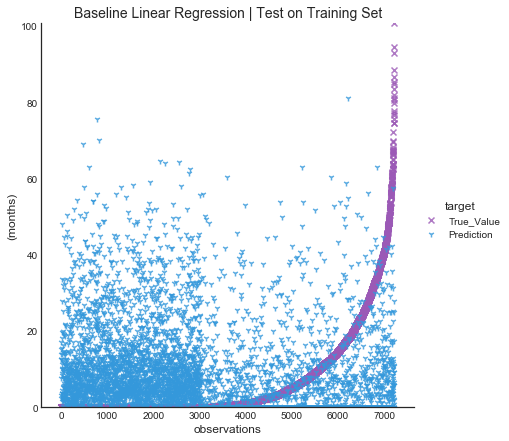

>> MSE: 65.19
>> MAE: 4.34
>> R2: 0.69


/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


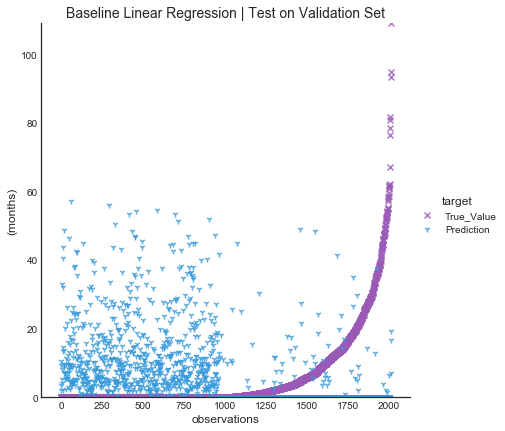

>> MSE: 29588376925797.29
>> MAE: 216973.73
>> R2: -132622162168.14


In [39]:
# baseline model
baselineLR = DummyLinReg()

baselineLR.train(X_train, y_train)
baselineLR._eval(X_train, y_train, 'Baseline Linear Regression | Test on Training Set')
baselineLR._eval(X_valid, y_valid, 'Baseline Linear Regression | Test on Validation Set')

The disparity between the Linear Regressor's train/validation set performances suggests that the dummy features are likely to be too many/noisy. Let's instead compute a higher baseline with a median dummy regressor instead.

In [47]:
def dumReg(X_train, y_train, X_valid, y_valid):
    X_train, le_dict =  dummy_prep_trainX(X_train)
    X_valid = dummy_prep_testX(X_valid, le_dict)
    
    Dum = dummy.DummyRegressor(strategy="median")
    Dum.fit(X_train, y_train)
    
    print("Performance on training set:")
    standard_eval(y_train, Dum.predict(X_train), graph = False)
    print("Performance on validation set:")
    standard_eval(y_valid, Dum.predict(X_valid), graph = False)
    

In [48]:
dumReg(X_train, y_train, X_valid, y_valid)

Performance on training set:
>> MSE: 242.23
>> MAE: 9.95
>> R2: -0.17
Performance on validation set:
>> MSE: 255.95
>> MAE: 9.92
>> R2: -0.15


#### Best Performing Classifier in Literature

[Loghmanpour et al.](http://d-scholarship.pitt.edu/25529/) etrospectively analyzed 8,050 continuous flow LVAD patients and 226 preimplant variables. We then derived Bayesian models for mortality at each of five time end-points postimplant (30 days, 90 days, 6 month, 1 year, and 2 years), achieving accuracies of 95%, 90%, 90%, 83%, and 78%, and area under the receiver operator characteristic (AUROC) of 91%, 82%, 82%, 80%, and 81%, respectively. CV evaluation.

In [180]:
def bucket_y(y, bucket_array = [0, 1, 3, 6, 12, 24, np.inf]):
    '''
    :param: Series of continous numbers
    :return: Series of categorical values
    '''
    y = [str(yi) for yi in pd.cut(y, bucket_array)]
    return pd.Series(y)

In [634]:
def clf_standard_eval(ytrue, yhat, verbose = True):
    '''
    transform regressor predictions into categorical
    to evaluate accuracy in terms of endpoint survival (1mo, 3mo, 6mo, 1 yr, 2yr)
    @params: ytrue (Series) and yhat (Series)
    '''
    yhat = bucket_y(yhat, [-np.inf, 1, 3, 6, 12, 24, np.inf])
    ytrue = bucket_y(ytrue, [-np.inf, 1, 3, 6, 12, 24, np.inf])
    
    accu = metrics.accuracy_score(ytrue, yhat)
    f1 = metrics.f1_score(ytrue, yhat, average = 'weighted')
    if verbose:
        print('accuracy: {0:.2f}%'.format(accu))
        print('F1: {0:.2f}%'.format(f1))
        print(metrics.classification_report(ytrue, yhat))
    
    return accu

In [ ]:
def dummpyClf(X_train, y_train, X_valid, y_valid):
    # transform y from numeric to categorical
    y_train = bucket_y(y_train)
    y_valid = bucket_y(y_valid)

    X_train =  dummy_prep_X(X_train)
    X_valid = dummy_prep_X(X_valid)

    n_classes = len(y_valid.unique())

    # multi-class classifier
#     clf = multiclass.OneVsRestClassifier(dummy.DummyClassifier(strategy="most_frequent"))
#     clf.fit(X_train, y_train)
#     y_hat = clf.predict(X_valid)
#     print('Validation accuracy: {0:.2f}%'.format(metrics.accuracy_score(y_valid, y_hat) * 100))

    for label in sorted(y_valid.unique()):
        y_traini = (y_train == label).astype('int') # binary classes
        y_validi = (y_valid == label).astype('int')
        
        clf = dummy.DummyClassifier(strategy="stratified")
        clf.fit(X_train, y_traini)
        y_scores = clf.predict_proba(X_valid)
        y_hati = clf.predict(X_valid)
        
        print('Target: %s months survival' % label)
        print('>> AUROC: {0:.2f}%'.format(metrics.roc_auc_score(np.array(y_validi),y_hati) * 100 ))
        print('>> validation accuracy: {0:.2f}%'.format(metrics.accuracy_score(y_validi, y_hati) * 100))
        
        # plot_roc(clf, X_valid, y_validi)

In [ ]:
dummpyClf(X_train, y_train, X_valid, y_valid)

### Intuitions: 

The inherent characteristics of this dataset posed several challenges to machine learning. These characteristics anchored many choices we made in data cleaning and the later modeling process.
- Feature selection. sparse data / missing values, feature redundancy
- 90 days and 6 months fits their Bayesian models relatively poorly
- Explainabile models only

---
<a id="cleaning"></a>
## 3 - Data Exploration, Cleaning and Visualization

<a id="3-1"></a>
#### Overview and Transform Prediction targets

Knowing that historically some targets (mortality interval of certain lenght) are more difficult to predict than others, I look into the distribution of these targets. If appropriate, I can potantially transform the targets to make them easier to fit with relatively simple models (i.e. linear models).

In [ ]:
min(y_train), max(y_train)

In [ ]:
Counter(round(y_train,9) < 1)

In [ ]:
def plot_y_hist(X_train, y_train, to_file = False):
    fig, ax = plt.subplots()
    ax = y_train.hist(figsize=(12, 4), bins = 110, density = True, color = 'black', edgecolor = 'white')
    ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in ax.get_yticks()])
    ax.set_title('INT_DEATH distribution (time interval between surgery and death)')
    plt.xlabel('(months)')
    
    if to_file == True:
        plt.savefig('plot/viz1.eps', format='eps', dpi=300)
    plt.show()
    
plot_y_hist(X_train, y_train, to_file = True)

In [ ]:
def plot_y_log_prob(X_train, y_train, to_file = False):
    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(111)
    y_train_log = np.log(y_train) # log1p inverse: np.expm1
    stats.probplot((y_train_log - np.mean(y_train_log))/np.std(y_train_log),plot=plt)
    ax.get_lines()[0].set_markerfacecolor('dimgray')
    ax.get_lines()[0].set_alpha(0.1)
    ax.get_lines()[0].set_markeredgecolor('black')
    ax.get_lines()[1].set_color('orangered')
    if to_file == True:
        plt.savefig('plot/viz2.eps', format='eps', dpi=300)
    plt.show()

plot_y_log_prob(X_train, y_train, to_file = False)

In [ ]:
def plot_nyha(X_train, y_train_log, to_file = False):

    nyha_fig = plt.figure(figsize=(20, 3))
    nyha_fig.suptitle('log(INT_DEATH)', fontsize=14)
    pos = 161
    for nyha, group in X_train.groupby('NYHA'):
        yi = y_train_log[group.index]
        ax = nyha_fig.add_subplot(pos)
        stats.probplot((yi - np.mean(yi))/np.std(yi),plot=ax)
        ax.get_lines()[0].set_markerfacecolor('dimgray')
        ax.get_lines()[0].set_alpha(0.3)
        ax.get_lines()[0].set_markeredgecolor('black')
        ax.get_lines()[1].set_color('orangered')
        if nyha == '-':
            nyha = 'Unknown'
        ax.set_title("NYHA %s -- %d Patients" % (nyha, len(yi)), fontsize = 14)
        pos += 1

    plt.subplots_adjust(left=0.1, wspace=0.2, top=0.8)
    if to_file == True:
        plt.savefig('plot/viz3.eps', format='eps', dpi=300)
    plt.show()

plot_nyha(X_train, np.log(y_train), to_file = False)

In [ ]:
# baseline model
BL = DummyLinReg()
BL.train(X_train, np.log(y_train))
print('Training:')
BL._eval(X_train, np.log(y_train), 'DummyLinReg log(y) | Test on Training Set')
print('Validation:')
BL._eval(X_valid, np.log(y_valid), 'DummyLinReg log(y) | Test on Validation Set')

In [ ]:
dumReg(X_train, np.log(y_train), X_valid, np.log(y_valid))

So we will potentially build differet models for this 

In [ ]:
highrisk_mask = (y_train <= 1).values
lowrisk_mask = (y_train >= 12).values
midrisk_mask = [not (a or b) for (a,b) in zip(highrisk_mask, lowrisk_mask)]

highrisk_mask2 = (y_valid <= 1).values
lowrisk_mask2 = (y_valid >= 12).values
midrisk_mask2 = [not (a or b) for (a,b) in zip(highrisk_mask2, lowrisk_mask2)]

<a id="3-2"></a>
#### Dealing with and Utilizing (Lots of) Missing Values: 

In [ ]:
print('# of missing value:', X_train.isnull().sum().sum()) # 1521691
print('% of missing value:', "{0:.2f}%".format(X_train.isnull().sum().sum() * 100 / (len(X_train) * len(X_train.columns))))

In [ ]:
def plot_na(X):
    '''
    :param: training data (df)
    '''
    
    fig, ax = plt.subplots(1,2, figsize=(12,3))
    
    # plot % of missing value in each column
    na_ptg = [ cent/len(X) for cent in X.isnull().sum().values]
    sns.distplot(na_ptg, kde=False, bins = 25, ax=ax[0])
    
    xticks = ax[0].get_xticks()
    ax[0].set_xticklabels(['{:.0f}%'.format(x * 100) for x in xticks])
    ax[0].set_title('% of Missing Value Per Column')
    
    sns.distplot([ptg for ptg in na_ptg if ptg > 0.9], kde=False, bins = 10, ax=ax[1])
    xticks = ax[1].get_xticks()
    ax[1].set_xticklabels(['{:.0f}%'.format(x * 100) for x in xticks])
    ax[1].set_title('% of Missing Value Per Column (close-up)')

plot_na(X_train)

To take a closer look, I used [msno.matrix nullity matrix](https://github.com/ResidentMario/missingno), a data-dense display which quickly visually picks out patterns in data completion. The sparkline at right summarizes the general shape of the data completeness and points out the maximum and minimum rows. 

In [ ]:
from quilt.data.ResidentMario import missingno_data
import missingno as msno

# Note that msno visualization accommodates up to 50 labelled variables.
# This dataframe exceeds this range thus labels begin to overlap or become unreadable.
# Therefore I divided up the dataframe for closer inspection.

i = 0
for Xi in np.array_split(X_train, 15, axis = 1):
    msno.matrix(Xi.sample(100))
    plt.savefig('plot/na_pattern_%s.png' % str(i), dpi=300)
    i += 1

These visualizations surfaces some interesting data completion patterns. Most significantly, some patients share a very similar set missing values. For example, variables that represent different _Concerns and Contraindications_ (columns that start with `CC_`) are missing for the almost exactly same set of patients.

In [ ]:
msno.matrix(X_train[[col for col in X_train.columns if col.startswith('CC_')]])
plt.show()

Clustering patients by their missing values, you can see that for each patient the range of their missing value in is actually correlates with their survival. This correlation is even more significant than some of the clinical test results.

In [ ]:
def plot_na_y(X_train, y_train, to_file = True):
    # plot na_cnt ~ INT_DEAD
    X_train['na_cnt'] = X_train.isnull().sum(axis = 1).copy()
    fig = plt.figure(figsize=(20, 4))
    ax = fig.add_subplot(111)
    sns.regplot(x="na_cnt", y="INT_DEAD",
                data=X_train.join(y_train).sort_values('NYHA'))
    if to_file == True:
        plt.savefig('plot/na_cnt.eps', format='eps', dpi=300)
    
    # plot na_cnt within vs. out of [200,230] 
    X_train['na_cnt_category'] = X_train['na_cnt'].map(lambda x: x > 200 and x < 230)
    
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111)
    sns.boxplot(x="na_cnt_category", y="INT_DEAD",
                data=X_train.join(y_train).sort_values(by=['NYHA']))
    
    if to_file == True:
        plt.savefig('plot/na_cnt_category.eps', format='eps', dpi=300)
    
    print('Correlation between # of missing value and INT_DEAD: %.3f' % X_train['na_cnt'].corr(y_train))
    print('p value: %.3f' % stats.ttest_ind(X_train['na_cnt'], y_train)[1])
    print('Correlation between # of missing value and INT_DEAD: %.3f' % X_train['na_cnt_category'].astype('float64').corr(y_train))
    print('p value: %.3f' % stats.ttest_ind(X_train['na_cnt_category'].astype('float64'), y_train)[1])

In [ ]:
plot_na_y(X_train, y_train, to_file = True)

_... Therefore I added missing value statistics into the feature space._

In [419]:
def add_na_stat(Xtest):
    Xtest['na_cnt'] = Xtest.isnull().sum(axis = 1)
    Xtest['na_cnt_category'] = Xtest['na_cnt'].map(lambda x: x > 200 and x < 230)
    return Xtest

X_train = add_na_stat(X_train)
X_valid = add_na_stat(X_valid)
X_test = add_na_stat(X_test)
Xa = add_na_stat(Xa)

/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<a id="3-3"></a>
#### Managing Feature Redundancy

In [235]:
def trim_features(Xtrain, ytrain, k = 10):
    '''
    @param: k (int) number of features to preserve
    '''
    selector = feature_selection.SelectKBest(feature_selection.f_regression, k)
    selector.fit(Xtrain, ytrain)
    return  selector, selector.transform(Xtrain)

In [236]:
def clf_trim_features(Xtrain, ytrain, k = 10):
    '''
    @param: k (int) number of features to preserve
    '''
    selector = feature_selection.SelectKBest(feature_selection.f_classif, k)
    selector.fit(Xtrain, ytrain)
    return  selector, selector.transform(Xtrain)

<a id="3-4"></a>
#### Managing Observation Redundancy

In [164]:
def trim_trainX_outlier(X, y, verbose = False):
    '''
    remove outlier observations that significantly affect model fitting;
    used in LR;
    :param: X features (df), y labels (series)
    :return: X features (df), y labels (np.array)
    '''
    
    y = np.array(y) # re-index
    
    # train a LR model
    regr = LinearRegression()
    regr.fit(X, y)
    y_pred = regr.predict(X)
    
    if verbose:
        print("Start removing outlier observations...")
        print("MSE on training before: %d" % np.mean((y - y_pred)**2)) 

    # find outlier observations
    idx_to_remove = []
    
    res = [(y_pred[i] - y[i])**2 for i in range(len(y_pred))]
    res_med = np.median(res)
    
    for i in range(len(y_pred)):
        resi = (y_pred[i] - y[i])**2
        if(resi > res_med):
            idx_to_remove.append(i)

    # delete outlier observations in reverse order
    # so that I don't throw off the subsequent indexes.
    for idx in sorted(idx_to_remove, reverse=True):
        y = np.delete(y, idx)
    
    X = X.drop(X.index[idx_to_remove])
    
    # check if performance is better with outlier observations removed
    regr2 = LinearRegression().fit(X, y)
    y_pred2 = regr2.predict(X)
    
    if verbose:
        print("MSE on training after: %d" % np.mean((y - y_pred2)**2))
    
#     svr_rbf = svm.SVR(kernel='rbf', C=1e3, gamma=0.1)
#     svr_rbf.fit(X,y)
#     y_pred3 = svr_rbf.predict(X)
#     print("MSE after (SVR rbf): %d" % np.mean((y - y_pred3)**2))
    
    return X , y

---
<a id="ML"></a>
## 4 - Supervised Learning

### 4.1 - Linear Regression

Procedure:
fill NAs with 'NaN' in categorical cols, encoding, clean_training_data, transform

In [163]:
def transform_trainX(x, poly = True, verbose = False):
    '''
    Polynomial transformation to a feature vector for a single instance;
    Used in LR;
  
    :param x: a feature vector for a single instance
    :return: a modified feature vector
    '''
    if verbose:
        print('transform start', x.shape) 
    
    if poly == True:
        poly = preprocessing.PolynomialFeatures(2, interaction_only = True) # polynomial transform produces more than 11k features
        poly = poly.fit(x)
        x = poly.transform(x) # 2nd degree polynomial interpolation
        
        if verbose:
            print('column count after poly', x.shape[1])
    else:
        poly = None
    
    norm = preprocessing.Normalizer()
    norm = norm.fit(x)
    x = norm.transform(x) # normalize the features
    
    imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)
    x = imp.fit_transform(x) #fill in expected values

    scaler = preprocessing.RobustScaler().fit(x)
    x = scaler.transform(x)
    
    return x, poly, norm, imp, scaler

In [55]:
class linear(model): 
    def __init__(self): # #add new attribute
        self.weights = []
        self.le = None
        self.poly = None # fitted polynominal transform obj
        self.norm = None # fitted normalization obj
        self.scale = None 
        model.__init__(self)
        
    def train(self, X, y):
        """
        Train a linear regression model
        :parma X: n (# of observations) x p (# of features) design matrix
        :param y: response vector of length n
        :return weights: weight vector of length p
        """
        X, self.le = dummy_prep_trainX(X)
        
        X , y = trim_trainX_outlier(X, y)
        X, self.poly, self.norm, self.imp, self.scaler = transform_trainX(X)
        
        self.feature_selector, X = trim_features(X, y)

        regr = LinearRegression(fit_intercept=False)
        regr.fit(X, y)
        self.model = regr
        self.weights = regr.coef_ 
    
    def prep_X(self, X):
        '''
        preprocess new incoming features
        :param: X (df)
        '''
        X1 = dummy_prep_testX(X, self.le)

        Xpoly = self.poly.transform(X1)
        X2 = self.norm.transform(Xpoly)
        X3 = self.imp.transform(X2)
        X4 = self.scaler.transform(X3)
        
        X5 = self.feature_selector.transform(X4)
        
        return X5
        
    # to-do inherent func from parent class Model
    
    def predict(self, Xtest):
        Xtest = self.prep_X(Xtest)
        return self.model.predict(Xtest)

    def _eval(self, Xtest, ytest, graph_title = 'untitled', standard_evaluation = True):
        yhat = self.model.predict(self.prep_X(Xtest))

        if standard_evaluation:
            standard_eval(ytest, yhat, graph_title)
        else:
            return yhat


Start removing outlier observations...
MSE on training before: 64
MSE on training after: 0
transform start (2095, 485)
column count after poly 117856


/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


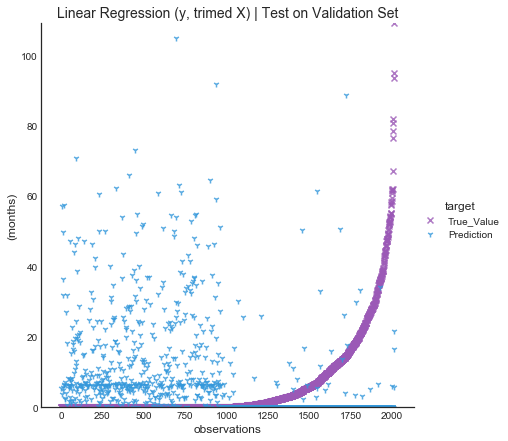

>> MSE: 155.26
>> MAE: 7.66
>> R2: 0.30


In [56]:
LR = linear()
LR.train(X_train, y_train)
LR._eval(X_valid, y_valid, 'Linear Regression (y, trimed X) | Test on Validation Set')

/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/qyang1/anaconda2/envs/py35/lib

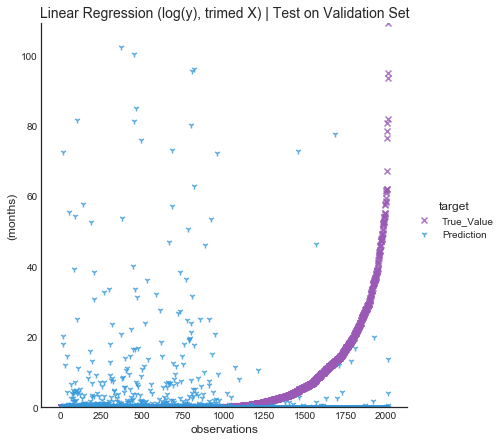

>> MSE: 61865.03
>> MAE: 24.76
>> R2: -276.29


In [506]:
def LR_log_wrapper(X_train, y_train, X_valid, y_valid):
    LR = linear()
    LR.train(X_train, np.log(y_train + 1))
    log_yhat = LR._eval(X_valid, y_valid, standard_evaluation = False)

    yhat = np.exp(log_yhat) - 1
    standard_eval(y_valid, yhat, 'Linear Regression (log(y), trimed X) | Test on Validation Set')
    
LR_log_wrapper(X_train, y_train, X_valid, y_valid)

### 4.2 - Support Vector Machine

In [408]:
class _SVM(model): 
    
    def __init__(self):
        self.le = None
        self.norm = None # fitted normalization obj
        self.scale = None
        model.__init__(self)
        
    def train(self, X, y , k = 10):
        
        X, self.le = dummy_prep_trainX(X)
        
        X , y = trim_trainX_outlier(X, y)
        X, _, self.norm, self.imp, self.scaler = transform_trainX(X, poly = False)
        
        self.feature_selector, X = trim_features(X, y, k)
        
        regr = svm.SVR(kernel='rbf', C=1e3, gamma=0.1)
        regr.fit(X,y)
        self.model = regr
    
    def prep_X(self, Xtest):
        '''
        preprocess new incoming features
        :param: X (df)
        '''
        X1 = dummy_prep_testX(Xtest, self.le)

        X2 = self.norm.transform(X1)
        X3 = self.imp.transform(X2)
        X4 = self.scaler.transform(X3)
        
        X5 = self.feature_selector.transform(X4)
        
        return X5
        
    def predict(self, Xtest):
        return self.model.predict(Xtest)

    def _eval(self, Xtest, ytest,
              graph_title = 'untitled',
              standard_evaluation = True,
              graph = True):
        
        Xtest = self.prep_X(Xtest)
        yhat = self.predict(Xtest)

        if standard_evaluation:
            standard_eval(ytest, yhat, graph_title, graph)
        else:
            return yhat
        
    def clf_eval(self, Xtest, ytest, verbose = True):
        Xtest = self.prep_X(Xtest)
        yhat = self.predict(Xtest)

        accu = clf_standard_eval(ytest, yhat, verbose)
        return accu

/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


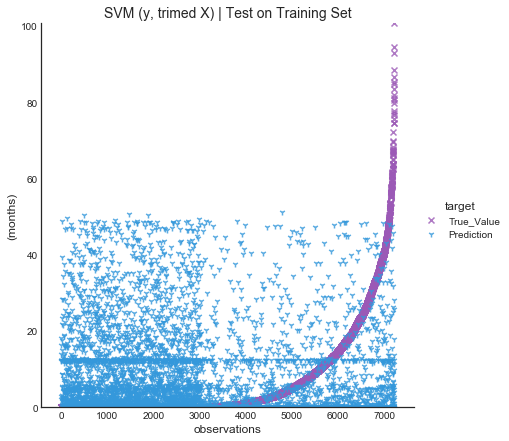

>> MSE: 84.19
>> MAE: 3.48
>> R2: 0.59


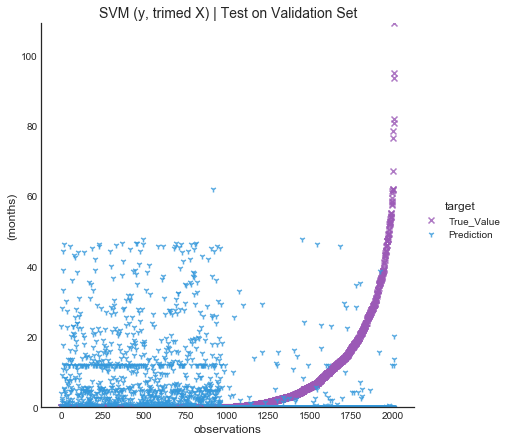

>> MSE: 112.46
>> MAE: 3.81
>> R2: 0.50


In [409]:
svm1 = _SVM()
svm1.train(X_train, y_train)
svm1._eval(X_train, y_train, 'SVM (y, trimed X) | Test on Training Set')
svm1._eval(X_valid, y_valid, 'SVM (y, trimed X) | Test on Validation Set')

In [256]:
# Evaluating its performance on predicting endpoint survival rates:
svm1.clf_eval(X_valid, y_valid)

accuracy: 0.70%
              precision    recall  f1-score   support

 (-inf, 1.0]       0.90      0.61      0.73       230
  (1.0, 3.0]       0.72      0.68      0.70       181
(12.0, 24.0]       0.79      0.75      0.77       178
 (24.0, inf]       0.87      0.78      0.82       170
  (3.0, 6.0]       0.53      0.76      0.63       139
 (6.0, 12.0]       0.52      0.69      0.59       150

 avg / total       0.74      0.70      0.71      1048



0.7041984732824428

/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


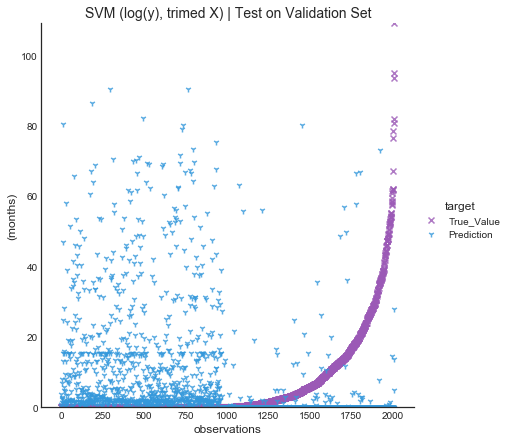

>> MSE: 219.69
>> MAE: 7.84
>> R2: 0.02
accuracy: 0.28%
              precision    recall  f1-score   support

 (-inf, 1.0]       0.68      0.62      0.65       230
  (1.0, 3.0]       0.25      0.81      0.38       181
(12.0, 24.0]       0.00      0.00      0.00       178
 (24.0, inf]       0.00      0.00      0.00       170
  (3.0, 6.0]       0.01      0.01      0.01       139
 (6.0, 12.0]       0.00      0.00      0.00       150

 avg / total       0.19      0.28      0.21      1048



/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [510]:
def SVM_log_wrapper(X_train, y_train, X_valid, y_valid):
    svm2 = _SVM()
    svm2.train(X_train, np.log(y_train + 1))
    log_yhat = svm2._eval(X_valid, y_valid, standard_evaluation = False)

    yhat = np.exp(log_yhat) - 1
    standard_eval(y_valid, yhat, 'SVM (log(y), trimed X) | Test on Validation Set')
    svm2.clf_eval(X_valid, y_valid)
    
SVM_log_wrapper(X_train, y_train, X_valid, y_valid)

#### Selecting the number of features (selected by ANOVA) to preserve for SVM
Here I look into the relationship between k and SVM performance, in order to select the best k.

In [263]:
def plot_svm_k(X_train, y_train, X_valid, y_valid, k = np.arange(10,200,10)):
    '''
    plot the relationship between k (# of features selected by ANOVA) and svm accuracy
    @param: k (list) the k values to try
    '''
    accu = []
    for i in k:
        svmi = _SVM()
        svmi.train(X_train, y_train, i)
        accu.append(svmi.clf_eval(X_valid, y_valid, verbose = False))
     
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(111)
    ax.scatter(k, accu)
    ax.set_xlabel("k (# of features)")
    ax.set_ylabel("SVM accuracy")
    ax.grid()
    plt.show()

/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predict

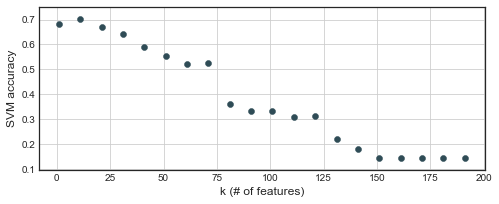

In [265]:
# !! alert: This function takes some time to run
plot_svm_k(X_train, y_train, X_valid, y_valid, k = np.arange(1,200,10))
plot.title('Selecting the Number of Features to Use for SVM')

Looks like the best k is smaller than 20. Let's zoom in.

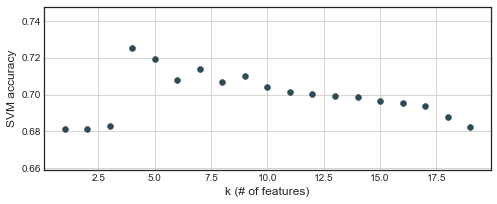

In [615]:
plot_svm_k(X_train, y_train, X_valid, y_valid, k = np.arange(1,20,1))
plot.title('Selecting the Number of Features to Use for SVM (Zoom In)')

This graph suggests k=4 produce the highest accuracy, and it does improve the performance marginally.

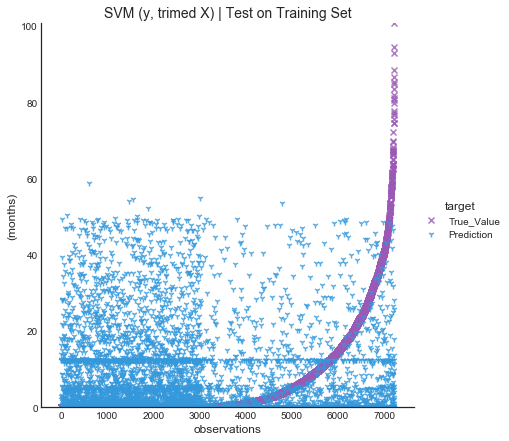

>> MSE: 83.48
>> MAE: 3.45
>> R2: 0.60


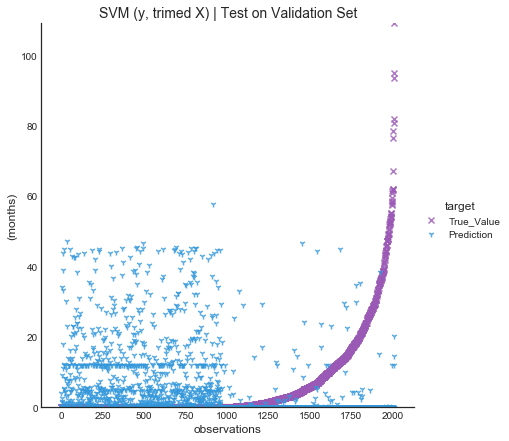

>> MSE: 110.25
>> MAE: 3.68
>> R2: 0.51


In [601]:
svm3 = _SVM()
svm3.train(X_train, y_train, 4)
svm3._eval(X_train, y_train, 'SVM (y, trimed X) | Test on Training Set')
svm3._eval(X_valid, y_valid, 'SVM (y, trimed X) | Test on Validation Set')

In [ ]:
svm3.clf_eval(X_valid, y_valid)

<a id="4-3"></a>
### 4.3 - Decision Trees

In [251]:
class dt(model):
    def __init__(self, leaf_size=4):
        self.leaf_size= leaf_size
        self.model = None
        self.le = None
        self.poly = None
        self.norm = None
        self.imp = None
        self.scaler = None
    
    def prep_Xtrain(self, Xtrain):
        Xtrain, self.le = dummy_prep_trainX(Xtrain)
        Xtrain, self.poly, self.norm, self.imp, self.scaler = transform_trainX(Xtrain, poly = False)
        return Xtrain
        
    def prep_Xtest(self, X):
        X = dummy_prep_testX(X, self.le)

        X = self.norm.transform(X)
        X = self.imp.transform(X)
        X = self.scaler.transform(X)
        
        return X 
    
    def train(self, dataX, dataY):
        '''
        @param: dataX is the output of self.prep_Xtrain(Xtrain)
                !! Xtrain cannot be prepped inside of this function between 
                   this trian func will run iteratively until tree nodes merge
        '''

        dataX = np.array(dataX)
        dataY = np.array(dataY)
        
        if dataX.shape[0] <= self.leaf_size: 
            return np.array([-1,np.mean(dataY),np.nan,np.nan])
        if np.all(dataY[:]==dataY[0]): 
            return np.array([-1,dataY[0],np.nan,np.nan])
        if np.all(dataX[:]==dataX[0]): 
            return np.array([-1,dataX[0],np.nan,np.nan])
        
        #Calc the index of the best feature.
        
        index = 0;
        cor_list = [];
        for i in range(len(dataX[0])):
            cor_list.append(abs(np.corrcoef(dataX[:,i], dataY)[0,1]))
        index = cor_list.index(max(cor_list))
        
        #split the tree by most significant feature.
        
        leaf = np.array([-1, Counter(dataY).most_common(1)[0][0], np.nan, np.nan])
        split_value = np.mean(dataX[:,index])
        left = dataX[:,index]<=split_value
        right = dataX[:,index]>split_value
        ldataX = dataX[left,:]
        ldataY = dataY[left]
        rdataX = dataX[right,:]
        rdataY = dataY[right]
                  
        if(len(rdataY)==0 or len(ldataX)==0 ):
                  return leaf
        
        #recursive train left and right node of the tree then merge at the end 
        ltree=self.train(ldataX,ldataY)
        rtree=self.train(rdataX,rdataY)
        if ltree.ndim==1:
            root=np.array([index,split_value,1,2])
        else:
            root=np.array([index,split_value,1,ltree.shape[0]+1])
        tree = np.vstack((root,ltree,rtree))
                      
        self.model = tree
        
        return tree
    
    def predict(self, Xtest):

        res = []
        start = int(self.model[0,0])
        tree_height = self.model.shape[0]
        for point in Xtest:
            index = start
            i=0
            while(i < tree_height):
                index = self.model[i,0]
                if index == -1:
                    break
                else:
                    index=int(index)
                if point[index] <= self.model[i,1]:
                    i = i + 1
                    
                else:
                    i = i + int(self.model[i,3])
                
            if index == -1:
                res.append(self.model[i,1])
            else:
                res.append(np.nan)

        return np.array(res)
    
    def _eval(self, Xtest, ytest, graph_title = 'untitled', standard_evaluation = True):
        Xtest = self.prep_Xtest(Xtest)
        yhat = self.predict(np.array(Xtest))

        if standard_evaluation:
            standard_eval(ytest, yhat, graph_title)
        else:
            return yhat

In [ ]:
def tree_wrapper(X_train, y_train, X_valid, y_valid, evaluation = True):
    tree = dt()
    prepped_Xtrain = tree.prep_Xtrain(X_train)
    _model = tree.train(prepped_Xtrain, y_train)
    
    yhat = tree._eval(X_valid, y_valid, standard_evaluation = False)
    
    if evaluation:
        tree._eval(X_train, y_train, 'DT (y, norm X) | Test on Training Set')
        tree._eval(X_valid, y_valid, 'DT (y, norm X) | Test on Validation Set')
        clf_standard_eval(y_valid, yhat)
    else:
        return _model
    
tree_wrapper(X_train, y_train, X_valid, y_valid, evaluation = True)

### 4.4 Gaussian Classifier

In [571]:
class Gaussian(model): 
    def __init__(self):
        self.le = None
        self.poly = None # fitted polynominal transform obj
        self.norm = None # fitted normalization obj
        self.scale = None
        self.model_fix = None
        self.model_opt = None
        model.__init__(self)
        
    def train(self, X, y, k = 10):
        
        X, self.le = dummy_prep_trainX(X)
        X , y = trim_trainX_outlier(X, y)
        X, self.poly, self.norm, self.imp, self.scaler = transform_trainX(X, poly = False)
        self.feature_selector, X = trim_features(X, y, k)
        
        y = bucket_y(y, [-np.inf, 1, 3, 6, 12, 24, np.inf])
        
        # Specify Gaussian Processes with fixed and optimized hyperparameters
        gp_fix = gaussian_process.GaussianProcessClassifier(kernel=1.0 * gaussian_process.kernels.RBF(length_scale=1.0),
                                                            optimizer=None)
        gp_fix.fit(X, y)
        self.model_fix = gp_fix

        gp_opt = gaussian_process.GaussianProcessClassifier(kernel=1.0 * gaussian_process.kernels.RBF(length_scale=1.0))
        gp_opt.fit(X, y)
        self.model_opt = gp_opt
        
    
    def prep_X(self, Xtest):
        '''
        preprocess new incoming features
        :param: X (df)
        '''
        X1 = dummy_prep_testX(Xtest, self.le)

        # X = self.poly.transform(X)
        X2 = self.norm.transform(X1)
        X3 = self.imp.transform(X2)
        X4 = self.scaler.transform(X3)
        
        X5 = self.feature_selector.transform(X4)
        
        return X5

    def _eval(self, Xtest, ytest,
              graph_title = 'untitled',
              standard_evaluation = True,
              graph = True):
        
        Xtest = self.prep_X(Xtest)
        yhat_opt = self.model_opt.predict(Xtest)
        yhat_fix = self.model_fix.predict(Xtest)
        
        print("Log Marginal Likelihood (initial): %.2f"
              % self.model_fix.log_marginal_likelihood(self.model_fix.kernel_.theta))
        print("Log Marginal Likelihood (optimized): %.2f"
              % self.model_opt.log_marginal_likelihood(self.model_opt.kernel_.theta))

#         print("Accuracy on validation set: %.2f (initial) %.2f (optimized)"
#               % (metrics.accuracy_score(ytest, yhat_fix),
#                  metrics.accuracy_score(ytest, yhat_opt)))

        if standard_evaluation:
            standard_eval(ytest, yhat_opt, graph_title, graph)

        return yhat_fix, yhat_opt
        
    def clf_eval(self, Xtest, ytest, verbose = True):
        Xtest = self.prep_X(Xtest)
        yhat = self.predict(Xtest)

        accu = clf_standard_eval(ytest, yhat, verbose)
        return accu

In [572]:
gc = Gaussian()
gc.train(X_train, y_train)

/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/qyang1/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/gaussian_process/gpc.py:430: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'warnflag': 2, 'grad'

Log Marginal Likelihood (initial): -600.49
Log Marginal Likelihood (optimized): -384.18


TypeError: unsupported operand type(s) for +: 'float' and 'str'

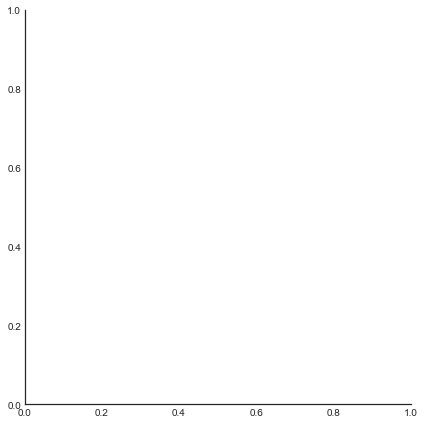

In [573]:
yhat_fix, yhat_opt = gc._eval(X_valid, y_valid)

In [574]:
yhat_fix

NameError: name 'yhat_fix' is not defined

#### Summary of Supervised Learning and Next Step

So far SVM (coupling with polynomial transformation, ANOVA feature selection and RBF kernel) has the best performance. However, on two endpoints the model performs less well than others: predicting 1-3 mo and 1-2 years survivals, even though the class distribution is roughly even. Contrarily, trees have better performance on 1-2 years, yet less so on other end points.

Given these observations and the non-linear nature of the input data, I decide to tune the model seperately for patients which seem the most and least risky.

In [275]:
Counter(bucket_y(y_valid, [-np.inf, 1, 3, 6, 12, 24, np.inf]))

Counter({'(-inf, 1.0]': 230,
         '(1.0, 3.0]': 181,
         '(12.0, 24.0]': 178,
         '(24.0, inf]': 170,
         '(3.0, 6.0]': 139,
         '(6.0, 12.0]': 150})

---
<a id="divide"></a>
## 5 - Divide and Conquer

Meta classifier to see if the patient is high, mid or low risk (INT_DEAD < 1, [1,12] or >12)

#### Meta Risk Classifier

In [562]:
class metaClf(model): 
    def __init__(self):
        self.metaClf_k = 0 # feature # for meta clf
        self.le = None
        self.poly = None # fitted polynominal transform obj
        self.norm = None # fitted normalization obj
        self.scale = None 
        self.feature_selector = None
        self.bucket_array = None
        model.__init__(self) # meta classifier
        self.submodels = {}
        self.population = {}
        
    def prep_trainX(self, X, y, k): 
        '''
        for the meta classifier
        '''
        self.metaClf_k = k
        y_clf = bucket_y(y, self.bucket_array)
        
        X, self.le = dummy_prep_trainX(X)
        X, _, self.norm, self.imp, self.scaler = transform_trainX(X, poly = False)
        
        self.feature_selector, X = clf_trim_features(X, y_clf, k)
        return pd.DataFrame(X), y_clf
    
    def prep_testX(self, Xtest):
        '''
        preprocess new incoming features
        :param: X (df)
        '''
        X1 = dummy_prep_testX(Xtest, self.le)

        X2 = self.norm.transform(X1)
        X3 = self.imp.transform(X2)
        X4 = self.scaler.transform(X3)
        X5 = self.feature_selector.transform(X4)
        return X5

    def train(self, X, y, metaClf_k = 10, bucket_array = [-np.inf, 1, 3, 6, 12, 24, np.inf]):
        """
        Train a classifier for some ranges of INT_DEAD defined by bucket_array
        :parma X: n (# of observations) x p (# of features) design matrix
        :param y: INT_DEAD (numeric)
        """
        self.bucket_array = bucket_array
        y = y.values # drop indexes
        
        # train a meta-classifier
        preppedX, y_clf = self.prep_trainX(X, y, metaClf_k)

        # build patient risk classifier
        clf = ensemble.GradientBoostingClassifier()
        clf.fit(X = preppedX, y = y_clf)
        self.model = clf
        
        # train a sub model for patients of each risk category
        for cat in y_clf.unique():
            
            print('*** Start building model %s ***' % cat)
            
            # slice the data 
            idx = [i for i, value in enumerate(y_clf) if value == cat]
            Xi = preppedX.loc[idx]
            yi = [y[i] for i in idx]
            
            svmi = svm.SVR(C=1.0, epsilon=0.2, gamma = 0.1)
            svmi.fit(Xi, yi)
            self.submodels[cat] = svmi

    def predict_and_eval(self, Xtest, ytest, standard_evaluation = True):
        
        # predict risk category
        Xtest_selected = self.prep_testX(Xtest)
        Xtest_risk_est = self.model.predict(Xtest_selected)
        
        ytest = ytest.values
        yhat = pd.Series()
        
        # apply the model of each risk category to responding cases
        for cat in np.unique(Xtest_risk_est):
            yhati = self.submodels[cat].predict(Xtest_selected)
            mask = Xtest_risk_est == cat
            idx = [i for i, x in enumerate(mask) if x]
            yhat = yhat.append(pd.Series(yhati[mask], index = idx), ignore_index = True)
            
            print('%s MAE: ' % cat, round(metrics.mean_absolute_error(ytest[mask], yhati[mask]),2))
        
        yhat = yhat.sort_index()
        
        # evaluate general performance
        if standard_evaluation:
            standard_eval(pd.Series(ytest), yhat, 'Meta Clf + SVM | On Validation Set')
        else:
            clf_standard_eval(pd.Series(ytest), yhat)
            return yhat

    def Clfpredict_and_eval(self, Xtest, ytest):

        yhat = self.predict_and_eval(Xtest, ytest, standard_evaluation = False) # numeric pred
        clf_standard_eval(ytest, yhat)


In [595]:
meta = metaClf()
meta.train(X_train, y_train, 10)

*** Start building model (12.0, 24.0] ***
*** Start building model (3.0, 6.0] ***
*** Start building model (-inf, 1.0] ***
*** Start building model (6.0, 12.0] ***
*** Start building model (24.0, inf] ***
*** Start building model (1.0, 3.0] ***


(-inf, 1.0] MAE:  3.14
(1.0, 3.0] MAE:  2.82
(12.0, 24.0] MAE:  6.42
(24.0, inf] MAE:  8.33
(3.0, 6.0] MAE:  2.87
(6.0, 12.0] MAE:  3.8


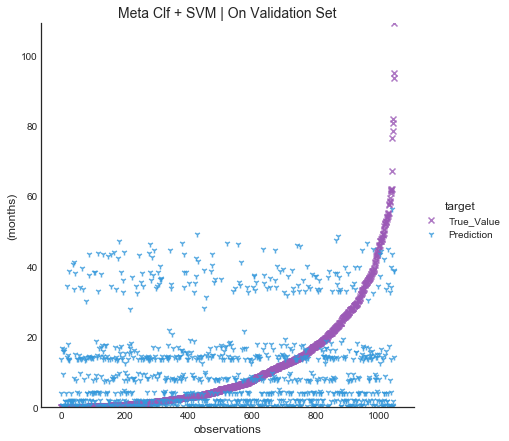

>> MSE: 359.33
>> MAE: 13.51
>> R2: -0.61


In [564]:
meta.predict_and_eval(X_valid, y_valid)

This 'divide and conquer' method (classifying patients into different level of riskiness and models for each) indeed provided even better performance, even when all these sub-models are all SVMs. This somewhat validated my earlier speculation. 

Following this direction, I handle the most long-surviving subset of patients seperately. This approach is proven indeed improve model generalizability.

** Penalizing Errors on Long-Surviving Patients **

In [ ]:
class mixedClf(model): 
    def __init__(self):
        self.metaClf_k = 0 # feature # for meta clf
        self.le = None
        self.poly = None # fitted polynominal transform obj
        self.norm = None # fitted normalization obj
        self.scale = None 
        self.feature_selector = None
        self.bucket_array = None
        model.__init__(self) # meta classifier
        self.submodels = {}
        self.population = {}
        
    def prep_trainX(self, X, y, k): 
        '''
        for the meta classifier
        '''
        self.metaClf_k = k
        y_clf = bucket_y(y, self.bucket_array)
        
        X, self.le = dummy_prep_trainX(X)
        X, _, self.norm, self.imp, self.scaler = transform_trainX(X, poly = False)
        
        self.feature_selector, X = clf_trim_features(X, y_clf, k)
        return pd.DataFrame(X), y_clf
    
    def prep_testX(self, Xtest):
        '''
        preprocess new incoming features
        :param: X (df)
        '''
        X1 = dummy_prep_testX(Xtest, self.le)

        X2 = self.norm.transform(X1)
        X3 = self.imp.transform(X2)
        X4 = self.scaler.transform(X3)
        X5 = self.feature_selector.transform(X4)
        return X5

    def train(self, X, y, metaClf_k = 10, bucket_array = [-np.inf, 1, 3, 6, 12, 24, np.inf]):
        """
        Train a classifier for some ranges of INT_DEAD defined by bucket_array
        :parma X: n (# of observations) x p (# of features) design matrix
        :param y: INT_DEAD (numeric)
        """
        self.bucket_array = bucket_array
        y = y.values # drop indexes
        
        # train a meta-classifier
        preppedX, y_clf = self.prep_trainX(X, y, metaClf_k)
        
        # build a model on all training data
        modelBig = _SVM()
        modelBig.train(X_train, y_train, metaClf_k)

        # build patient risk classifier
#         clf = ensemble.GradientBoostingClassifier()
#         clf.fit(X = preppedX, y = y_clf)
#         self.model = clf
        
        most_risky_class = [a for a in y_clf.unique() if a.endswith('inf]')]
        clf = svm.SVC(class_weight = {most_risky_class[0]: 20}) # penalizing errors on long-survival patients
        clf.fit(X = preppedX, y = y_clf)
        self.model = clf

        
        # train a sub model for patients of each risk category
        for cat in y_clf.unique():
            
            # slice the data 
            idx = [i for i, value in enumerate(y_clf) if value == cat]
            Xi = preppedX.loc[idx]
            yi = [y[i] for i in idx]
            
#             svmi = svm.SVR(C=1.0, epsilon=0.2, gamma = 0.1)
#             svmi.fit(Xi, yi)

            modeli = neighbors.KNeighborsRegressor(weights = 'distance', algorithm='ball_tree').fit(Xi, yi)
            
            modelBigR2 = abs(modelBig.model.score(Xi, yi))
            iR2 = abs(modeli.score(Xi, yi))
            
            if modelBigR2 <= iR2:
                print('model ', cat)
                self.submodels[cat] = modelBig
            else:
                print('model (specialized)', cat)
                self.submodels[cat] = modeli
            

    def predict_and_eval(self, Xtest, ytest, standard_evaluation = True):
        
        # predict risk category
        Xtest_selected = self.prep_testX(Xtest)
        Xtest_risk_est = self.model.predict(Xtest_selected)
        
        ytest = ytest.values
        yhat = pd.Series()
        
        # apply the model of each risk category to responding cases
        for cat in np.unique(Xtest_risk_est):
            yhati = self.submodels[cat].predict(Xtest_selected)
            mask = Xtest_risk_est == cat
            idx = [i for i, x in enumerate(mask) if x]
            yhat = yhat.append(pd.Series(yhati[mask], index = idx), ignore_index = True)
            
            print('%s MAE: ' % cat, round(metrics.mean_absolute_error(ytest[mask], yhati[mask]),2))
        
        yhat = yhat.sort_index()
        
        # evaluate general performance
        if standard_evaluation:
            standard_eval(pd.Series(ytest), yhat, 'Meta Clf + SVM | On Validation Set')
        else:
            clf_standard_eval(pd.Series(ytest), yhat)
            return yhat

    def Clfpredict_and_eval(self, Xtest, ytest):

        yhat = self.predict_and_eval(Xtest, ytest, standard_evaluation = False) # numeric pred
        clf_standard_eval(ytest, yhat)


In [ ]:
mixed = mixedClf()
mixed.train(X_train, y_train, 10)

In [ ]:
mixed.predict_and_eval(X_train, y_train)

In [ ]:
mixed.Clfpredict_and_eval(X_valid, y_valid)

---
<a id="others"></a>

## 5 - Explorations for Future Work

#### Prognostic Fairness
Heart disease occurances inherently differ across different racial, gender and age groups because of genetic encodings. In 2006, the ratios of black to white by gender admitted with primary diagnosis of Heart Failure was **9:1**. This anchored the INTERMAC data bring dominantly white male. 

In [617]:
def plot_representation(df):
    '''
    plot the age, gender and race compositions in the data (df)
    '''
    
    # slience the df slice warning
    df.is_copy = False
    
    # plot age, gender, racial distribution in the data
    df.loc[:,'AGE'] = df.AGE_GRP.str[3:5].astype(float)
    g = sns.FacetGrid(df.loc[:,('AGE','GENDER','RACE_WHITE')],
                      row = "GENDER",
                      col= "RACE_WHITE",
                      margin_titles=True,
                     size = 3)
    g = g.map(sns.distplot, 'AGE', bins = 7, kde=False).set_titles("WHITE {col_name} | {row_name}")
    
    # Adjust the arrangement of the plots
    g.fig.subplots_adjust(wspace=0.6)
    g.set(xlim=(10,80))

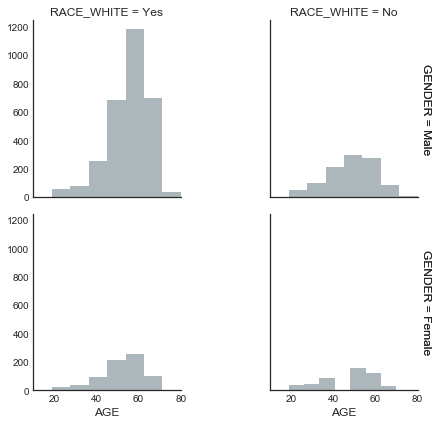

In [623]:
plot_representation(Xa)

Because of such highly skewed representation, it's quite likely that the model built on the whole population is less predictive on the minority groups. I run the following analysis to see if this speculation is true.

In [624]:
def faireness_eval(Xtest_col, ytest, yhat, graph_title):
    '''
    Check a model's predictions vary across different demographic groups
    @param: Xtest_col (pd.Series) a categorical column of Xtest that notes demographic groups
            can be 'AGE', 'GENDER', 'RACE_WHITE'
    '''
    for cat in Xtest_col.unique():
        print(cat)
        idx = [i for i, value in enumerate(Xtest_col) if value == cat]
        ytesti = [ytest[i] for i in idx]
        yhati = [yhat[i] for i in idx]
        
        standard_eval(ytest, yhat, graph_title = graph_title + cat)

In [625]:
faireness_eval(X_valid['RACE_WHITE'], y_valid, yhat, 'RACE_WHITE')

NameError: name 'yhat' is not defined

In [ ]:
faireness_eval(X_valid['RACE_WHITE'], y_valid, yhat, 'RACE_WHITE')

---
<a id="sum"></a>

## 6 - Conclusions and Lessons Learned

        
30 days, 90 days, 6 month, 1 year, and 2 years
achieving accuracies of 95%, 90%, 90%, 83%, and 78%,
AUROC of 91%, 82%, 82%, 80%, and 81%, respectively. CV evaluation.



|    | Best Accuracy in Research Literature [[2](ref-2)] | This Project |
|:---:|:---:|:---:|
| 30 days  | 95%  | 88%
| 90 days  | 90% | 80%
| 6 months  | 90%  | 64%
| 1 year  | 83% | 68%
| 2 years  | 78% | 83%


---
<a id="ref"></a>

## 7 - References

<a id="ref-1"></a>
1. Husaini BA, Mensah GA, Sawyer D, et al. Race, Gender, and Age Differences in Heart Failure-Related Hospitalizations in a Southern State: Implications for Prevention. Circulation Heart failure. 2011;4(2):161-169. doi:10.1161/CIRCHEARTFAILURE.110.958306. [link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3070602/)
<a id="ref-2"></a>
2. 